# import

In [1]:
import random
import argparse
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from tensorboardX import SummaryWriter

import torchvision.utils as vutils

import gym
import gym.spaces

import numpy as np

# initialisation

In [2]:
log = gym.logger
log.set_level(gym.logger.INFO)

LATENT_VECTOR_SIZE = 100
DISCR_FILTERS = 64
GENER_FILTERS = 64
BATCH_SIZE = 16

# dimension input image will be rescaled
IMAGE_SIZE = 64

LEARNING_RATE = 0.0001
REPORT_EVERY_ITER = 100
SAVE_IMAGE_EVERY_ITER = 1000

# Class InputWrapper

In [3]:
class InputWrapper(gym.ObservationWrapper):
    """
    Preprocessing of input numpy array:
    1. resize image into predefined size
    2. move color channel axis to a first place
    """
    def __init__(self, *args):
        super(InputWrapper, self).__init__(*args)
        assert isinstance(self.observation_space, gym.spaces.Box)
        old_space = self.observation_space
        self.observation_space = gym.spaces.Box(self.observation(old_space.low), self.observation(old_space.high),
                                                dtype=np.float32)

    def observation(self, observation):
        # resize image
        new_obs = cv2.resize(observation, (IMAGE_SIZE, IMAGE_SIZE))
        # transform (210, 160, 3) -> (3, 210, 160)
        new_obs = np.moveaxis(new_obs, 2, 0)
        return new_obs.astype(np.float32)

# Discriminator

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        # this pipe converges image into the single number
        self.conv_pipe = nn.Sequential(
            nn.Conv2d(in_channels=input_shape[0], out_channels=DISCR_FILTERS,
                      kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS, out_channels=DISCR_FILTERS*2,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS*2),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 2, out_channels=DISCR_FILTERS * 4,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 4),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 4, out_channels=DISCR_FILTERS * 8,
                      kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(DISCR_FILTERS * 8),
            nn.ReLU(),
            nn.Conv2d(in_channels=DISCR_FILTERS * 8, out_channels=1,
                      kernel_size=4, stride=1, padding=0),
            nn.Sigmoid()
        )

    def forward(self, x):
        conv_out = self.conv_pipe(x)
        return conv_out.view(-1, 1).squeeze(dim=1)

# Generator

In [5]:
class Generator(nn.Module):
    def __init__(self, output_shape):
        super(Generator, self).__init__()
        # pipe deconvolves input vector into (3, 64, 64) image
        self.pipe = nn.Sequential(
            nn.ConvTranspose2d(in_channels=LATENT_VECTOR_SIZE, out_channels=GENER_FILTERS * 8,
                               kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(GENER_FILTERS * 8),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 8, out_channels=GENER_FILTERS * 4,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 4),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 4, out_channels=GENER_FILTERS * 2,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS * 2),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS * 2, out_channels=GENER_FILTERS,
                               kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(GENER_FILTERS),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=GENER_FILTERS, out_channels=output_shape[0],
                               kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.pipe(x)


# Iterate batches

In [6]:
def iterate_batches(envs, batch_size=BATCH_SIZE):
    batch = [e.reset() for e in envs]
    env_gen = iter(lambda: random.choice(envs), None)

    while True:
        e = next(env_gen)
        obs, reward, is_done, _ = e.step(e.action_space.sample())
        if np.mean(obs) > 0.01:
            batch.append(obs)
        if len(batch) == batch_size:
            # Normalising input between -1 to 1
            batch_np = np.array(batch, dtype=np.float32) * 2.0 / 255.0 - 1.0
            yield torch.tensor(batch_np)
            batch.clear()
        if is_done:
            e.reset()

# execution

In [7]:
# parser = argparse.ArgumentParser()
# parser.add_argument("--cuda", default=False, action='store_true', help="Enable cuda computation")
# args = parser.parse_args()

device = torch.device("cuda")
envs = [InputWrapper(gym.make(name)) for name in ('Breakout-v0', 'AirRaid-v0', 'Pong-v0')]
input_shape = envs[0].observation_space.shape

net_discr = Discriminator(input_shape=input_shape).to(device)
net_gener = Generator(output_shape=input_shape).to(device)

objective = nn.BCELoss()
gen_optimizer = optim.Adam(params=net_gener.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(params=net_discr.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
writer = SummaryWriter()

gen_losses = []
dis_losses = []
iter_no = 0

true_labels_v = torch.ones(BATCH_SIZE, dtype=torch.float32, device=device)
fake_labels_v = torch.zeros(BATCH_SIZE, dtype=torch.float32, device=device)

for batch_v in iterate_batches(envs):
    # generate extra fake samples, input is 4D: batch, filters, x, y
    gen_input_v = torch.FloatTensor(BATCH_SIZE, LATENT_VECTOR_SIZE, 1, 1).normal_(0, 1).to(device)
    batch_v = batch_v.to(device)
    gen_output_v = net_gener(gen_input_v)

    # train discriminator
    dis_optimizer.zero_grad()
    dis_output_true_v = net_discr(batch_v)
    dis_output_fake_v = net_discr(gen_output_v.detach())
    dis_loss = objective(dis_output_true_v, true_labels_v) + objective(dis_output_fake_v, fake_labels_v)
    dis_loss.backward()
    dis_optimizer.step()
    dis_losses.append(dis_loss.item())

    # train generator
    gen_optimizer.zero_grad()
    dis_output_v = net_discr(gen_output_v)
    gen_loss_v = objective(dis_output_v, true_labels_v)
    gen_loss_v.backward()
    gen_optimizer.step()
    gen_losses.append(gen_loss_v.item())

    iter_no += 1
    if iter_no % REPORT_EVERY_ITER == 0:
        log.info("Iter %d: gen_loss=%.3e, dis_loss=%.3e", iter_no, np.mean(gen_losses), np.mean(dis_losses))
        writer.add_scalar("gen_loss", np.mean(gen_losses), iter_no)
        writer.add_scalar("dis_loss", np.mean(dis_losses), iter_no)
        gen_losses = []
        dis_losses = []
    if iter_no % SAVE_IMAGE_EVERY_ITER == 0:
        writer.add_image("fake", vutils.make_grid(gen_output_v.data[:64], normalize=True), iter_no)
        writer.add_image("real", vutils.make_grid(batch_v.data[:64], normalize=True), iter_no)

INFO: Making new env: Breakout-v0


/home/explore/miniconda3/envs/drl_handson/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


INFO: Making new env: AirRaid-v0
INFO: Making new env: Pong-v0
INFO: Iter 100: gen_loss=4.424e+00, dis_loss=1.050e-01
INFO: Iter 200: gen_loss=6.157e+00, dis_loss=6.946e-03
INFO: Iter 300: gen_loss=6.792e+00, dis_loss=2.531e-03
INFO: Iter 400: gen_loss=7.264e+00, dis_loss=1.618e-03
INFO: Iter 500: gen_loss=7.589e+00, dis_loss=1.119e-03
INFO: Iter 600: gen_loss=7.794e+00, dis_loss=6.823e-04
INFO: Iter 700: gen_loss=7.867e+00, dis_loss=6.837e-04
INFO: Iter 800: gen_loss=7.895e+00, dis_loss=1.638e-01
INFO: Iter 900: gen_loss=5.956e+00, dis_loss=1.032e-01
INFO: Iter 1000: gen_loss=5.232e+00, dis_loss=2.079e-02
INFO: Iter 1100: gen_loss=5.009e+00, dis_loss=2.593e-01
INFO: Iter 1200: gen_loss=4.240e+00, dis_loss=2.946e-01
INFO: Iter 1300: gen_loss=3.828e+00, dis_loss=3.602e-01
INFO: Iter 1400: gen_loss=4.201e+00, dis_loss=2.496e-01
INFO: Iter 1500: gen_loss=3.875e+00, dis_loss=3.932e-01
INFO: Iter 1600: gen_loss=3.616e+00, dis_loss=3.385e-01
INFO: Iter 1700: gen_loss=3.735e+00, dis_loss=2.62

INFO: Iter 14600: gen_loss=7.323e+00, dis_loss=2.017e-02
INFO: Iter 14700: gen_loss=7.667e+00, dis_loss=3.918e-03
INFO: Iter 14800: gen_loss=8.438e+00, dis_loss=7.764e-03
INFO: Iter 14900: gen_loss=6.525e+00, dis_loss=1.884e-01
INFO: Iter 15000: gen_loss=7.539e+00, dis_loss=1.685e-02
INFO: Iter 15100: gen_loss=6.431e+00, dis_loss=2.888e-01
INFO: Iter 15200: gen_loss=6.877e+00, dis_loss=3.114e-02
INFO: Iter 15300: gen_loss=7.674e+00, dis_loss=4.658e-02
INFO: Iter 15400: gen_loss=7.104e+00, dis_loss=1.717e-01
INFO: Iter 15500: gen_loss=6.092e+00, dis_loss=1.467e-01
INFO: Iter 15600: gen_loss=6.795e+00, dis_loss=1.401e-02
INFO: Iter 15700: gen_loss=7.208e+00, dis_loss=1.413e-01
INFO: Iter 15800: gen_loss=6.237e+00, dis_loss=2.766e-02
INFO: Iter 15900: gen_loss=5.822e+00, dis_loss=1.722e-01
INFO: Iter 16000: gen_loss=6.460e+00, dis_loss=1.584e-01
INFO: Iter 16100: gen_loss=6.995e+00, dis_loss=2.520e-02
INFO: Iter 16200: gen_loss=6.573e+00, dis_loss=1.416e-01
INFO: Iter 16300: gen_loss=7.81

INFO: Iter 29000: gen_loss=5.715e+00, dis_loss=1.479e-01
INFO: Iter 29100: gen_loss=5.481e+00, dis_loss=7.210e-02
INFO: Iter 29200: gen_loss=5.864e+00, dis_loss=1.784e-01
INFO: Iter 29300: gen_loss=6.230e+00, dis_loss=9.469e-02
INFO: Iter 29400: gen_loss=6.404e+00, dis_loss=1.309e-01
INFO: Iter 29500: gen_loss=6.951e+00, dis_loss=4.963e-02
INFO: Iter 29600: gen_loss=7.065e+00, dis_loss=8.936e-02
INFO: Iter 29700: gen_loss=5.944e+00, dis_loss=8.463e-02
INFO: Iter 29800: gen_loss=6.460e+00, dis_loss=1.877e-01
INFO: Iter 29900: gen_loss=5.147e+00, dis_loss=6.265e-02
INFO: Iter 30000: gen_loss=5.648e+00, dis_loss=7.573e-02
INFO: Iter 30100: gen_loss=6.281e+00, dis_loss=2.116e-01
INFO: Iter 30200: gen_loss=6.446e+00, dis_loss=7.634e-02
INFO: Iter 30300: gen_loss=5.732e+00, dis_loss=2.290e-01
INFO: Iter 30400: gen_loss=6.107e+00, dis_loss=1.991e-01
INFO: Iter 30500: gen_loss=6.759e+00, dis_loss=1.155e-01
INFO: Iter 30600: gen_loss=5.927e+00, dis_loss=1.383e-01
INFO: Iter 30700: gen_loss=6.44

INFO: Iter 43400: gen_loss=7.795e+00, dis_loss=1.469e-01
INFO: Iter 43500: gen_loss=6.557e+00, dis_loss=9.975e-02
INFO: Iter 43600: gen_loss=6.983e+00, dis_loss=1.295e-01
INFO: Iter 43700: gen_loss=7.277e+00, dis_loss=2.186e-02
INFO: Iter 43800: gen_loss=6.880e+00, dis_loss=8.900e-02
INFO: Iter 43900: gen_loss=6.550e+00, dis_loss=1.726e-01
INFO: Iter 44000: gen_loss=7.166e+00, dis_loss=9.409e-02
INFO: Iter 44100: gen_loss=7.040e+00, dis_loss=5.606e-02
INFO: Iter 44200: gen_loss=6.454e+00, dis_loss=1.071e-01
INFO: Iter 44300: gen_loss=6.896e+00, dis_loss=1.484e-01
INFO: Iter 44400: gen_loss=7.160e+00, dis_loss=1.042e-01
INFO: Iter 44500: gen_loss=6.074e+00, dis_loss=2.179e-01
INFO: Iter 44600: gen_loss=6.660e+00, dis_loss=1.309e-01
INFO: Iter 44700: gen_loss=6.552e+00, dis_loss=8.105e-02
INFO: Iter 44800: gen_loss=6.234e+00, dis_loss=1.175e-01
INFO: Iter 44900: gen_loss=6.607e+00, dis_loss=5.630e-02
INFO: Iter 45000: gen_loss=7.580e+00, dis_loss=1.283e-01
INFO: Iter 45100: gen_loss=6.29

INFO: Iter 57800: gen_loss=6.293e+00, dis_loss=7.104e-02
INFO: Iter 57900: gen_loss=7.234e+00, dis_loss=1.026e-01
INFO: Iter 58000: gen_loss=7.597e+00, dis_loss=1.320e-01
INFO: Iter 58100: gen_loss=8.151e+00, dis_loss=7.671e-02
INFO: Iter 58200: gen_loss=7.780e+00, dis_loss=7.629e-02
INFO: Iter 58300: gen_loss=7.909e+00, dis_loss=1.884e-01
INFO: Iter 58400: gen_loss=6.668e+00, dis_loss=7.134e-02
INFO: Iter 58500: gen_loss=6.987e+00, dis_loss=4.243e-02
INFO: Iter 58600: gen_loss=7.215e+00, dis_loss=1.264e-01
INFO: Iter 58700: gen_loss=7.736e+00, dis_loss=4.036e-02
INFO: Iter 58800: gen_loss=7.395e+00, dis_loss=1.594e-01
INFO: Iter 58900: gen_loss=7.424e+00, dis_loss=6.864e-02
INFO: Iter 59000: gen_loss=7.999e+00, dis_loss=3.986e-02
INFO: Iter 59100: gen_loss=7.327e+00, dis_loss=6.362e-02
INFO: Iter 59200: gen_loss=6.798e+00, dis_loss=1.164e-01
INFO: Iter 59300: gen_loss=6.883e+00, dis_loss=1.993e-02
INFO: Iter 59400: gen_loss=8.229e+00, dis_loss=9.518e-02
INFO: Iter 59500: gen_loss=6.92

KeyboardInterrupt: 

## Results

file:///tmp/gnome-shell-screenshot-9ISEV0.png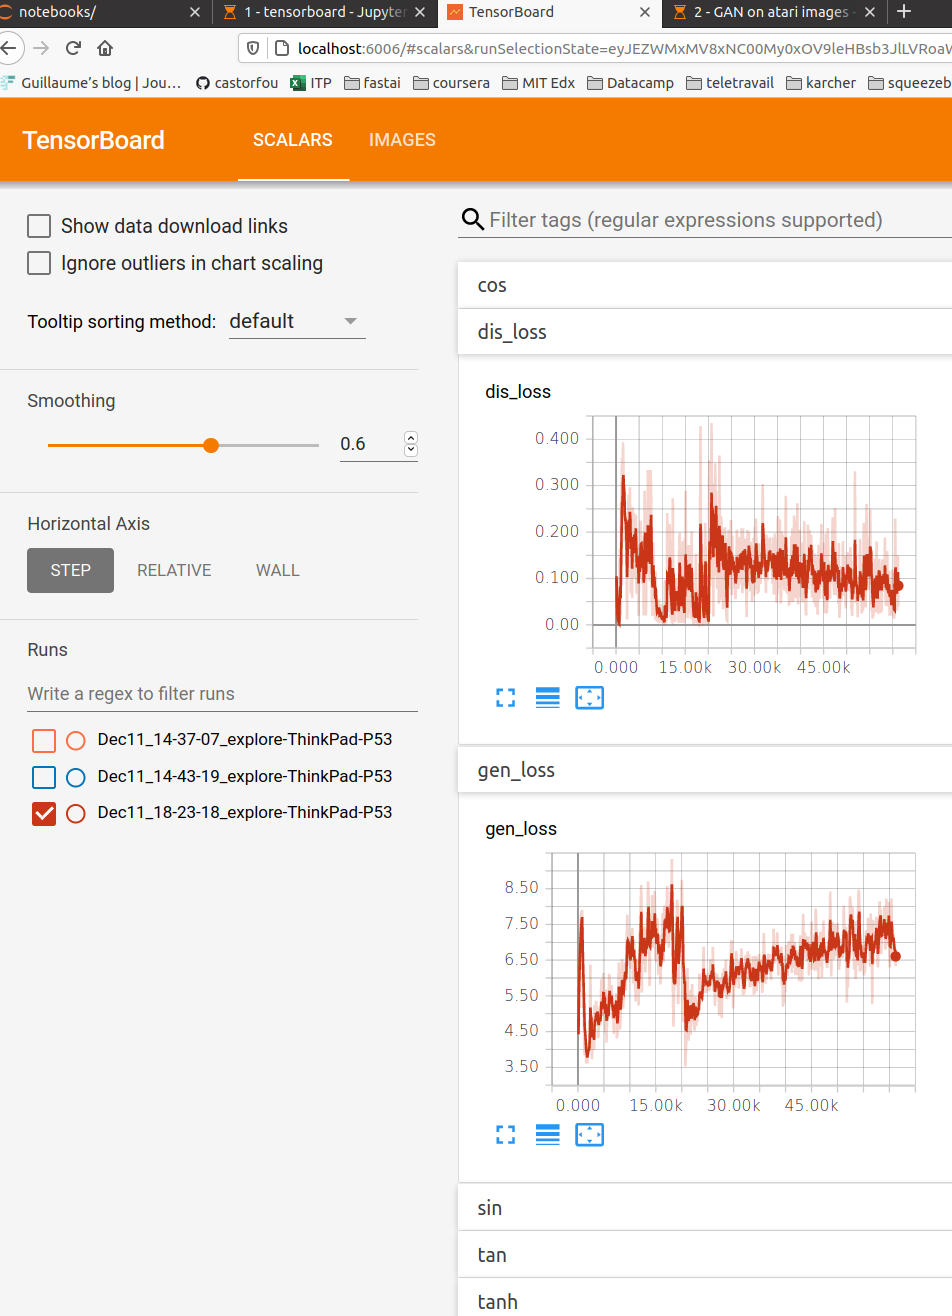

file:///tmp/gnome-shell-screenshot-AGLMV0.png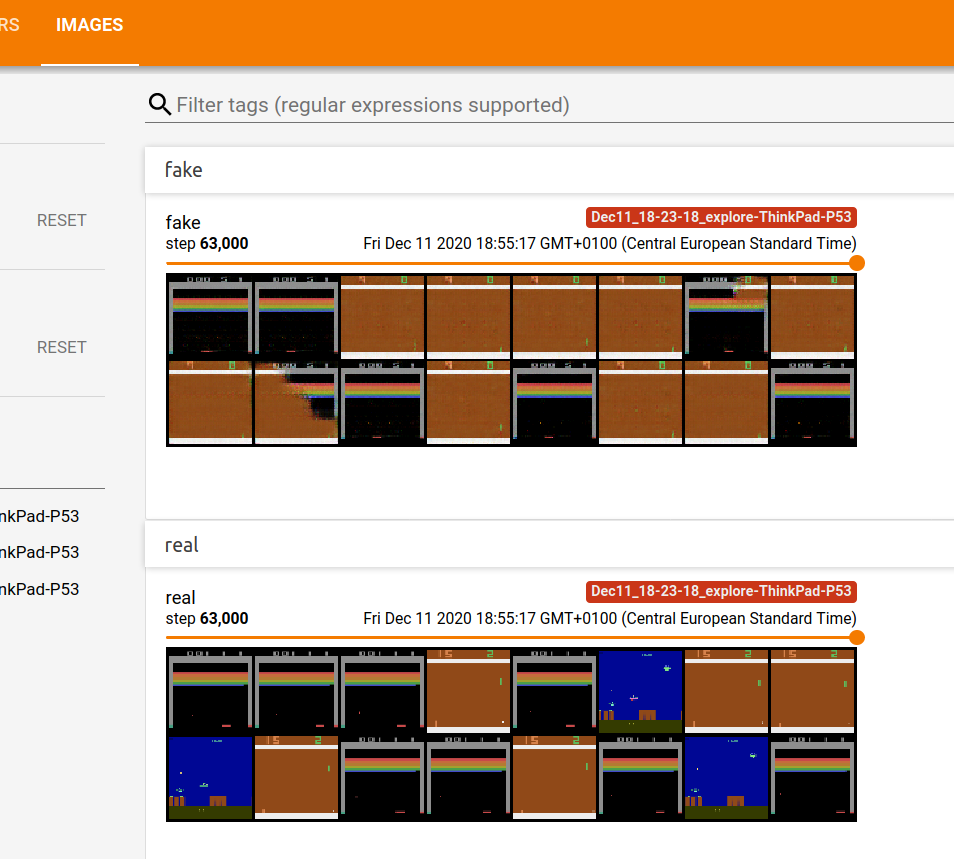